## [SIMPLIFIED] StackOverFlow Developer Survey Analysis

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import requests
import zipfile
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# filter the warning for now on
#import warnings
#warnings.simplefilter("ignore", DeprecationWarning)

# new way to create an ordered category
from pandas.api.types import CategoricalDtype

## OVERVIEW

As the business world adapts to the massive disrutption of internet and the consumer epxectations driven by unleashed by the first movers and innovators in Tech, DATA SCIENTISTS have become hightly sought after.  This has made it a very attractive career building on the customs and tools pioneered by individuals in Academic Science and Computer Programming disciplines. 

Data Science is a hot field; however, are the people doing "the best job in America" really any different from other developers?  Lets use the annual Stack Overflow Developers Survey to try and find out.


---
## DATASET Description:

The data set is the full, cleaned results of the 2019 Stack Overflow Developer Survey, downloaded from: <https://insights.stackoverflow.com/survey>.   The survey was fielded from January 23 to February 14, 2019. The median time spent on the survey for qualified responses was 23.3 minutes.  Unfortunately, free response submissions and personally identifying information have been removed from the pubicly available data in order to protect the privacy of respondents. 

Respondents were recruited primarily through channels owned by Stack Overflow. The top 5 sources of respondents were onsite messaging, blog posts, email lists, Meta posts, banner ads, and social media posts. Since respondents were recruited in this way, highly engaged users on Stack Overflow were more likely to notice the links for the survey and click to begin it. This community is _highly_ biased compared with the general population.  Heavy on white males from the US.



### Data Files

There two files of interest are a CSV table of results, and a schema table containing the questions.   For theis analysis we'll just need the survey.csv which we will download and save to a local file re-coded by the year in case we want to look at additional years of data in the future.

In [3]:
today = datetime.today()
survey_year = 2019
# in case we want to reuse code for other years
in_file = Path.cwd() / 'data' / 'raw' / f'survey{survey_year}.csv'
# this is where our cleaned up file will put put
summary_file = Path.cwd() / 'data' / 'processed' / 'summary_{today:%b-%d-%Y}.pkl'

In [4]:
# download the data if its not in the local directory
if not os.path.exists(in_file):
    # put these here in case we want to look at any other years...
    url = 'https://drive.google.com/uc?export=download&id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV'
    survey_filename = 'survey_results_public.csv'
    questions_filename = 'survey_results_schema.csv'
    print('Downloading {} survey'.format(survey_year))

    request = requests.get(url)
    with open('survey.zip', 'wb') as file:
        file.write(request.content)

    print('Unzipping {} survey'.format(survey_year))
    with zipfile.ZipFile("survey.zip", "r") as file:
        file.extractall("data/external/")

    print('Moving {} survey'.format(year))
    shutil.copytree('data/external', 'data/raw')
    shutil.copy('data/external/' + survey_filename,
                'data/raw/survey{}.csv'.format(survey_year))
    shutil.copy('data/external/' + questions_filename,
                'data/raw/schema{}.csv'.format(survey_year))

    print('cleaning up')
    os.remove('survey.zip')

---
##  OUTLINE

- 0: ABSTRACT
- 1: EXPLORE & FRAME 
    - Clean and Simplify Data 
        - Convert objects to category
        - derive some features 
    - describe & Plot
    
- 2: RESEARCH QUESTIONS
    - Are Data Scientists different? 
    
- 3: SUMMARRY AND NEXT STEPS
    - so what?


# EXPLORE 

## Describe the Data.

Lets look at what we have and what features we want to probe Data Scientists for.


>> Describe and explore your dataset in the initial section of your Report. What does your data contain and what is its background? Where does it come from? Why is it interesting or significant? Conduct summary statistics and produce visualizations for the particular variables from the dataset that you will use.    
    
    

In [5]:
# beware that the Respondent ids start at 1
df = pd.read_csv(in_file, index_col='Respondent')
# Print column name
df.columns


Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment',
       'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther',
       'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro',
       'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek',
       'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate',
       'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests',
       'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith',
       'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife', 'ITperson', 

The dataframe is nice and tidy:  no empty columns, mostly self-explanatory column names, etc. Only the columns resulting from multi-selections will be tricky.  These contain strings with semicolon separated values specifyng the selections.

---
First lets look at `MainBranch` which tells us "who" the respondents are --  Professional Developer, Student, Occational coder, Hobbiest, or retired Developer -- and then limit our scope to Professinals.

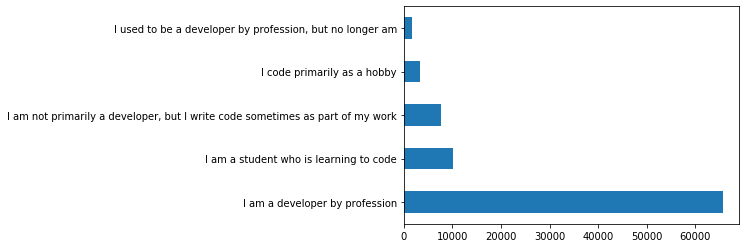

In [6]:
df['MainBranch'].value_counts().plot('barh')

In [7]:
# filter our respondents to be Professionals
df = df[df['MainBranch'] == 'I am a developer by profession']


In [8]:
print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')


The dataset contains 65679 rows and 84 columns.


In [9]:
#convert dtypes to categories for the features we want to analyze...
convert_to_cat = ['MainBranch', 'Gender', 'Trans', 'Sexuality', 'Ethnicity', 'Dependents', 'Student', 'UndergradMajor',
                  'Employment',  'OrgSize',
                  'CareerSat', 'BlockchainOrg', 'OpSys', 'OpenSourcer',
                  'MgrIdiot', 'MgrMoney', 'MgrWant', 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn', 'ScreenName', 'SocialMedia', 'Extraversion',
                  'SurveyLength', 'SurveyEase', 'Hobbyist']

for col_name in convert_to_cat:
    if(df[col_name].dtype == 'object'):
        df[col_name] = df[col_name].astype('category')
        # df.loc[:,col_name] = df[col_name].cat.codes  # could do this to make everything ready for ML

In [10]:
# Convert these to ordered categories
# Education
edlevel_cat = CategoricalDtype(['I never completed any formal education',
                                'Primary/elementary school',
                                'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                                'Some college/university study without earning a degree',
                                'Associate degree',
                                'Bachelor’s degree (BA, BS, B.Eng., etc.)',
                                'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                                'Professional degree (JD, MD, etc.)',
                                'Other doctoral degree (Ph.D, Ed.D., etc.)'], ordered=True)

df['EdLevel'] = df.EdLevel.astype(edlevel_cat)

# OpenSource . Higher, same lower
opensource_cat = CategoricalDtype(['OSS is, on average, of HIGHER quality than proprietary / closed source software',
                                   'The quality of OSS and closed source software is about the same',
                                   'OSS is, on average, of LOWER quality than proprietary / closed source software', ], ordered=True)
df['OpenSource'] = df.OpenSource.astype(opensource_cat)

# career satisfaction / job satisfaction\
careersat_cat = CategoricalDtype(['Very dissatisfied',
                                  'Slightly dissatisfied',
                                  'Neither satisfied nor dissatisfied',
                                  'Slightly satisfied',
                                  'Very satisfied'], ordered=True)
df['CareerSat'] = df.CareerSat.astype(careersat_cat)

jobsat_cat = CategoricalDtype(['Very dissatisfied',
                               'Slightly dissatisfied',
                               'Neither satisfied nor dissatisfied',
                               'Slightly satisfied',
                               'Very satisfied'], ordered=True)
df['JobSat'] = df.JobSat.astype(jobsat_cat)

# competence
impsyn_cat = CategoricalDtype(['Far below average',
                               'A little below average',
                               'Average',
                               'A little above average',
                               'Far above average'], ordered=True)
df['ImpSyn'] = df.ImpSyn.astype(impsyn_cat)

print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 65679 rows and 84 columns.


### Find our developer types

(is there a better name for this ?)

- KEEP PROFESSIONALS ONLY.  Dropped students and "other"
- CREATE TYPES
    - DataScientist
    - Non-DataScientists Developers 
    - xOR and Other    
        - Traditional Developers - not mutually exclusive from DataScientists since 
        - DataScients who are also "traditional" developers
        - Other: Developers who are not "traditional" developers or data scientsis

As we are interested in comparing data scientists to non-data scientists, we need to be able to differentiate between the two. This is done using the `DevType` field. As a result, we should drop any rows where this field is missing, since we can't determine which subset these rows fit into.


In [11]:
# Create data scientist and non-data scientist subsets.
# data scientists are defined as "Data or business analyst",Engineer, Data",
#       "Data scientist or machine learning specialist"
# Database administrator or Scientist

# developer is "Developer, {fullstack, game or graphics, mobile, QA or test}"
# exclude database administrator by having space after data
data_scientist = df['DevType'].str.contains(
        '|'.join(['data ', 'scientist']), case=False, na=False, regex=True).copy()  # data scientists / analists / Data engineers

# data = df['DevType'].str.contains('data', case=False, na=False, regex=True).copy() #data scientists / analists / Data engineers
developer = df['DevType'].str.contains(
        'developer', case=False, na=False, regex=True).copy()  # all types of developers


print('we have {} DataScientists and {} traditional Developers in our professional Developers database'.format(
          data_scientist.sum(), developer.sum()))

we have 8057 DataScientists and 61987 traditional Developers in our professional Developers database


In [12]:
# make some expository columns
df.loc[:, 'isDS'] = data_scientist
df.loc[:, 'isDev'] = developer
df.loc[:, 'notDS'] = ~data_scientist
df.loc[:, 'DSonly'] = data_scientist & ~developer
df.loc[:, 'DSandDev'] = data_scientist & developer
df.loc[:, 'otherDev'] = ~data_scientist & ~ developer

df[['isDS','notDS','isDev','DSonly','DSandDev','otherDev']].agg(['mean','sum'])


,isDS,notDS,isDev,DSonly,DSandDev,otherDev
mean,0.122672,0.877328,0.943787,0.019808,0.102864,0.036404
sum,8057.000000,57622.000000,61987.000000,1301.000000,6756.000000,2391.000000


Nothing surprising here:  Our set of developers tend to be white dudes from the US

### categorical variables
# Research Questions


In order to explore whether the cohort of Data Scientists are different from traditional Developers lets explore their DEMOGRAPHICS, their SKILLS, and some ATTITUDES/CULTURAL probes. 



2. Ask and answer analytic questions. Ask three analytic questions and answer each one with a combination of statistics and visualizations. These analytic questions can focus on individuals behaviors or comparisons of the population.



We can lump the variables into a few rough categories:  _DEMOGRAPHIC_, _WORK_ , _CODING_, _ATTITUDINAL_ (personal), _STACKOVERFLOW_, and _MISC_.  We'll focus in on DEMOGRAPHICS, CODING, and ATTITUDINAL features.  Features of most interest are `tagged` below.

> _DEMOGRAPHIC_ - `MainBranch`, `Age`, `Gender`, `Trans','Sexuality', 'Ethnicity', 'Dependents', 'Country', 'Student', 'EdLevel', 'UndergradMajor`, 'EduOther, 

> _ATTITUDINAL_ (personal/cultural) -  `ImpSyn'(personal competence), 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors', 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion', 'ScreenName', 'OpenSource`  

> _WORK_ related - `ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize`, (also:  'JobSeek', 'LastHireDate', 'LastInt',  'ResumeUpdate',   'CompTotal',    'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq',, 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests','PurchaseHow', 'PurchaseWhat', 
       
> _SKILLS_ related -  `YearsCode', 'Age1stCode`, `YearsCodePro`,`OpenSourcer', 'DevType',  'LanguageWorkedWith', 'LanguageDesireNextYear','DevEnviron', 'OpSys', 'Containers', 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',  MiscTechWorkedWith', 'MiscTechDesireNextYear', 'BlockchainOrg`, ( 
       'WebFrameWorkedWith',     'WebFrameDesireNextYear', ', , 'FizzBuzz', )
    
> *MISC* - `Hobbyist', 'SurveyLength', 'SurveyEase`
      
> _STACKOVERFLOW_ specific -  Ignore all these ('SOVisit1st','SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved',       'SOHowMuchTime', 'SOAccount', 'SOPartFreq', 'SOJobs', 'EntTeams',       'SOComm', 'WelcomeChange', 'SONewContent')
    
So lets keep DEMOGRAPHIC, some WORK related, CODING, and MISC for further analysis.

The motivation behind this analysis is to explore how data scientists compare with non-data scientist developers ("non-data scientists"). Consequently, we set out to answer the following questions:

1. Are there demographic differences?  Hypothesis:  higher educated and more likely from math/science than computer/tech.  Intuition also dictates that DS are younger and less experienced.
2. Are their attitudes different? 
3. Are their skills and work situations different?
3. Can we predict if a developer professional developer is a Data Scientist?
       
        

In [13]:
# df.columns
# Drop unnecessary columns
demographic_cols = ['MainBranch', 'Age', 'Gender', 'Trans', 'Sexuality', 'Ethnicity',
                    'Dependents', 'Country', 'Student', 'EdLevel', 'UndergradMajor']#, 'EduOther']

attitude_cols = ['ImpSyn', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors',
                 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion', 
                 'ScreenName', 'OpenSource']

work_cols = ['ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize']#, 
             #'JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',   
             #'CompTotal', 'CurrencySymbol','CurrencyDesc', 'CompTotal', 'CompFreq', 
             #'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests', 
             #'PurchaseHow', 'PurchaseWhat']

#keep all of these
skills_cols = ['YearsCode', 'Age1stCode', 'YearsCodePro', 'OpenSourcer', 'DevType',  'LanguageWorkedWith', 
               'LanguageDesireNextYear', 'DevEnviron', 'OpSys', 'Containers','BlockchainOrg','FizzBuzz',
               'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',  
               'MiscTechWorkedWith', 'MiscTechDesireNextYear', 'WebFrameWorkedWith','WebFrameDesireNextYear']

misc_cols = ['Hobbyist', 'SurveyLength', 'SurveyEase']

# drop all of these
stackoverflow_cols=['SOVisit1st', 'SOVisitFreq', 'SOVisitTo', 'SOFindAnswer', 'SOTimeSaved', 'SOHowMuchTime',
                   'SOAccount', 'SOPartFreq', 'SOJobs', 'EntTeams', 'SOComm', 'WelcomeChange', 'SONewContent']

# added columns
types_cols = ['isDS','notDS','isDev','DSonly','DSandDev','otherDev']

drop_cols = ['JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',
             'CompTotal', 'CurrencySymbol','CurrencyDesc', 'CompTotal', 'CompFreq',
             'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests', 
             'PurchaseHow', 'PurchaseWhat',
             'EduOther','SOVisit1st', 'SOVisitFreq', 'SOVisitTo', 'SOFindAnswer','SOTimeSaved', 'SOHowMuchTime',
             'SOAccount', 'SOPartFreq', 'SOJobs', 'EntTeams', 'SOComm', 'WelcomeChange', 'SONewContent']

df = df.drop(drop_cols,axis=1)

#df = df[keep_columns]

In [22]:
def plot_dev_vs_df(df_dev, df_ds, title_text, xlimit, ylabel_text):

    fig = plt.figure(figsize=(15, 12))
    grid_size = (10, 10)  # lets space stuff out...
    SOURCE_TEXT = 'Source: StackOverFlow Dev survey, 2019'

    #title_text = 'language LOVE (use now AND want to use it next year'
    #xlimit = {0,95} #

    xlabel_text = 'Incidence (pct)'

    # Place A Title On The Figure
    fig.text(x=0.995, y=0.02, s=SOURCE_TEXT, verticalalignment='bottom',
             rotation='vertical', color='#524939')
    # Overlay multiple plots onto the same axis, which spans 1 entire column of the figure
    tall_left_ax = plt.subplot2grid(grid_size, (1, 1), colspan=3, rowspan=9)
    tall_right_ax = plt.subplot2grid(grid_size, (1, 6), colspan=3, rowspan=9)

    #ax1 = lang_pct.plot.barh(ax=tall_left_ax,legend=False, title='All Respondents',label='xxx',x='string',y='lang')
    ax1 = df_dev.plot.barh(ax=tall_left_ax, 
                           legend=False, 
                           title='Developers').set(xlabel=xlabel_text, ylabel=ylabel_text, xlim=xlimit)
    ax2 = df_ds.plot.barh(ax=tall_right_ax, 
                          legend=False, 
                          title='Data Scientists').set(xlabel=xlabel_text, xlim=xlimit)
    # plt.tight_layout()
    plt.suptitle(title_text, fontsize=22)
    # should also move the ylabels to the right side for the second plot...

In [23]:
def plot_2col(df_dev, df_ds, title_text, xlimit, xlabel_text, ylabel_text):

    fig = plt.figure(figsize=(15, 12))
    grid_size = (10, 10)  # lets space stuff out...
    SOURCE_TEXT = 'Source: StackOverFlow Dev survey, 2019'

    #title_text = 'language LOVE (use now AND want to use it next year'
    #xlimit = {0,95} #

    #xlabel_text = 'Incidence (pct)'

    # Place A Title On The Figure
    fig.text(x=0.995, y=0.02, s=SOURCE_TEXT, verticalalignment='bottom',
             rotation='vertical', color='#524939')
    # Overlay multiple plots onto the same axis, which spans 1 entire column of the figure
    tall_left_ax = plt.subplot2grid(grid_size, (1, 1), colspan=3, rowspan=9)
    tall_right_ax = plt.subplot2grid(grid_size, (1, 6), colspan=3, rowspan=9)

    #ax1 = lang_pct.plot.barh(ax=tall_left_ax,legend=False, title='All Respondents',label='xxx',x='string',y='lang')
    ax1 = df_dev.plot.barh(ax=tall_left_ax, 
                           legend=False, title='Developers').set(xlabel=xlabel_text,
                                                                 ylabel=ylabel_text, 
                                                                 xlim=xlimit)
    ax2 = df_ds.plot.barh(ax=tall_right_ax, 
                          legend=False, 
                          title='Data Scientists').set(xlabel=xlabel_text, 
                                                       xlim=xlimit)
    # plt.tight_layout()
    plt.suptitle(title_text, fontsize=22)
    # should also move the ylabels to the right side for the second plot...

----
## QUESTION 1

1. Are there demographic differences?  

Hypothesis:  DS are higher educated and more likely from math/science than computer/tech.  Intuition also dictates that DS are younger and less experienced.


demographic_cols = ['MainBranch', 'Age', 'Gender', 'Trans', 'Sexuality', 'Ethnicity',
                    'Dependents', 'Country', 'Student', 'EdLevel', 'UndergradMajor']



### Demographic 1 - simplified Educaton and categories
    - Education: Advanced, College, Grade
    - Major: Computer/Tech, Math/Science, Other
  

In [14]:
# simple method comparing strings... could also use ordering...
advanced = df['EdLevel'].isin(['Other doctoral degree (Ph.D, Ed.D., etc.)',
                               'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                               'Professional degree (JD, MD, etc.)'])

college = df['EdLevel'].isin(['Associate degree',
                              'Bachelor’s degree (BA, BS, B.Eng., etc.)',
                              'Some college/university study without earning a degree'])

grade = df['EdLevel'].isin(['Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                            'Primary/elementary school',
                            'I never completed any formal education'])
no_answer = df['EdLevel'].isnull()
# create ordered category
edlevel_simple_cat = CategoricalDtype(['Grade',
                                       'College',  # 'N/A'
                                       'Advanced'], ordered=True)
df.loc[:, 'Education'] = np.nan
df.loc[advanced, 'Education'] = 'Advanced'
df.loc[college, 'Education'] = 'College'
df.loc[grade, 'Education'] = 'Grade'
# now make it an ordered category
df.loc[:, 'Education'] = df.Education.astype(edlevel_simple_cat)

df['Education'].value_counts()

College     42115
Advanced    18295
Grade        4016
Name: Education, dtype: int64

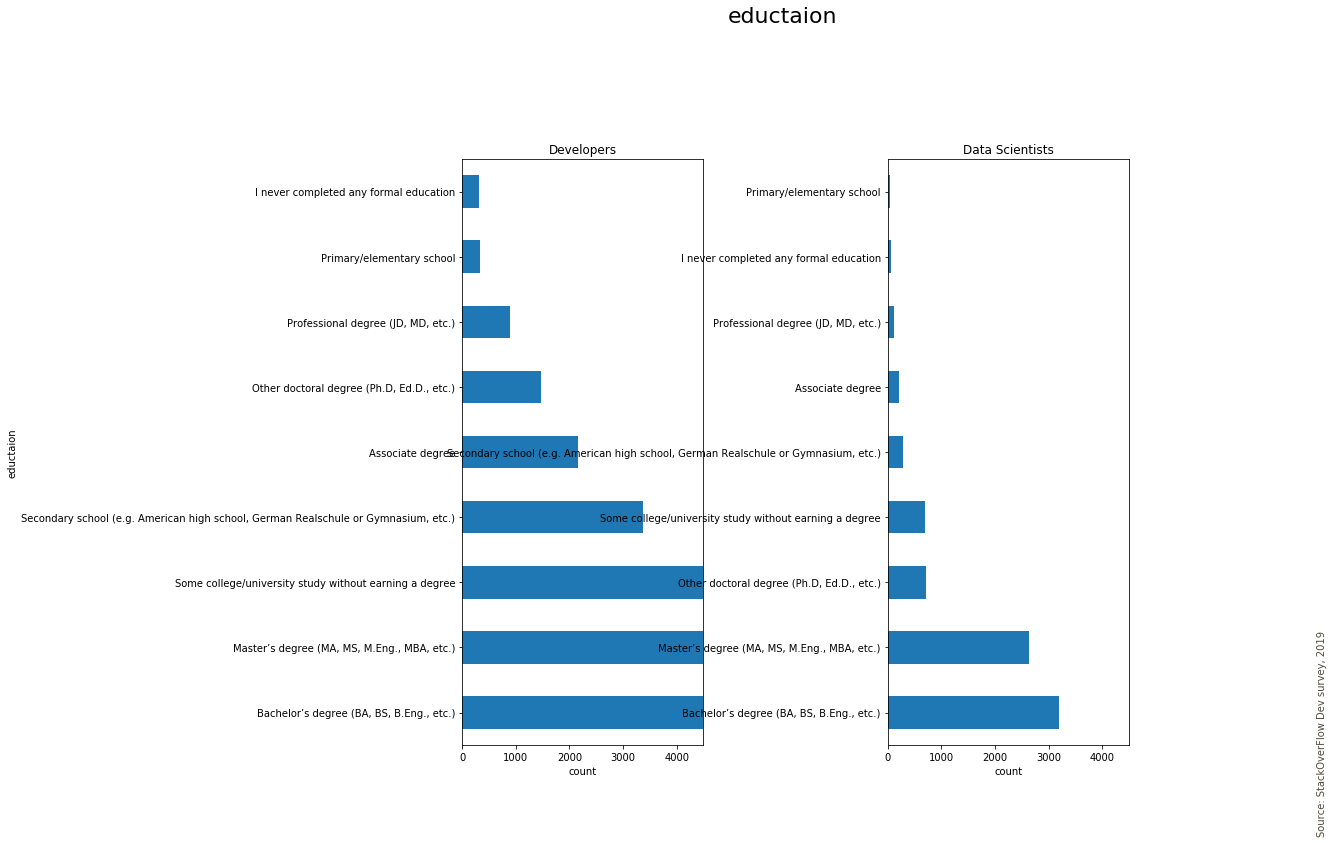

In [37]:
# plot EdLevel and Education summaries for DS and non-DS

title_text = 'eductaion'
xlimit = {0,4500}
xlabel_text = 'count'
ylabel_text = 'eductaion'
df_plot1 = df.EdLevel.value_counts()
df_plot2 = df.EdLevel[df['isDS']].value_counts()
plot_2col(df_plot1, df_plot2, title_text, xlimit, xlabel_text, ylabel_text)


In [16]:
# plot UndergradMajor and Major summaries for DS and non-DS

In [17]:
df.loc[:, 'Major'] = np.nan

computer_tech = df['UndergradMajor'].isin(['Computer science, computer engineering, or software engineering',
                                           'Web development or web design',
                                           'Information systems, information technology, or system administration'])

math_sci = df['UndergradMajor'].isin(['Mathematics or statistics',
                                      'Another engineering discipline (ex. civil, electrical, mechanical)',
                                      'A natural science (ex. biology, chemistry, physics)'])

other = df['UndergradMajor'].isin(['A health science (ex. nursing, pharmacy, radiology)',
                                   'A business discipline (ex. accounting, finance, marketing)',
                                   'A humanities discipline (ex. literature, history, philosophy)',
                                   'A social science (ex. anthropology, psychology, political science)',
                                   'Fine arts or performing arts (ex. graphic design, music, studio art)'])


df.loc[computer_tech, 'Major'] = 'Computer/Tech'
df.loc[math_sci, 'Major'] = 'Math/Science'
df.loc[other, 'Major'] = 'Other'
#df.loc[no_answer,'EdLevel_simple'] = 'N/A'

df.loc[:, 'Major'] = df.Major.astype('category')
df['Major'].value_counts()
# survey.UndergradMajor.cat.categories

Computer/Tech    46509
Math/Science      8697
Other             4244
Name: Major, dtype: int64

### Demographic 2 - coding experience compensation converted to values
    - convert Years coding and age started to numerical values
    - converted compensation to be meaningfuly numerical values
    - (Test that `ConvertedComp` is sensible?)
    
>work_cols = ['ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize']#, 
             #'JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',   
             #'CompTotal', 'CurrencySymbol','CurrencyDesc', 'CompTotal', 'CompFreq', 
             #'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests', 
             #'PurchaseHow', 'PurchaseWhat']

#keep all of these

>skills_cols = ['YearsCode', 'Age1stCode', 'YearsCodePro', 'OpenSourcer', 'DevType',  'LanguageWorkedWith', 
                       'LanguageDesireNextYear', 'DevEnviron', 'OpSys', 'Containers','BlockchainOrg','FizzBuzz',
                       'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',  



In [18]:
attitude_cols = ['ImpSyn', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors',
                 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion', 
                 'ScreenName', 'OpenSource']


In [19]:
def fix_years_coding(years_):
    # - years coding, years experience: `YearsCode` -> `nYearsCode`, change "Less than 1 year" to 1/10000 and "More than 50" to 55.
    # - years pro:`YearsCodePro` -> `nYearsPro`    
    # make these numeric in a sensible way
    if years_ == 'Less than 1 year':
        return 0.0001
    elif years_ == 'More than 50 years':
        return 55.
    else:
        return years_

df.loc[:, 'nYearsCode'] = pd.to_numeric(df.YearsCode.apply(fix_years_coding))
df.loc[:, 'nYearsPro'] = pd.to_numeric(df.YearsCodePro.apply(fix_years_coding))

In [20]:
def fix_workweekhours(hours_):
    # - workweek: `WorkWeekHrs` to require 4 hours off per day
    # hard ceiling on hours in a week (24*7)  lets throw out the ridiculous no sleep 24/7 scenarios
    if hours_ > 20*7:
        return np.NaN
    elif hours_ < 4:  # arbitrary minimum work time
        return np.NaN
    else:
        return hours_

df.loc[:, 'WorkWeekH'] = df.WorkWeekHrs.apply(fix_workweekhours)

In [21]:
def fix_age1stcode(years_):
    # - Age: `Age`-> `nAge`  change < 13, or > 80 to `NaN`
    if years_ == 'Younger than 5 years':
        return 4.5
    elif years_ == 'Older than 85':
        return 85.
    else:
        return years_

df.loc[:, 'nAgeCode'] = pd.to_numeric(df.Age1stCode.apply(fix_age1stcode))

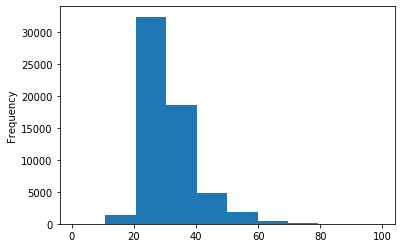

In [24]:
df.Age.plot.hist()

In [25]:
df['WorkWeekH'].dropna().describe()
# looks good

count    57721.000000
mean        40.299745
std          9.952120
min          4.000000
25%         40.000000
50%         40.000000
75%         43.000000
max        140.000000
Name: WorkWeekH, dtype: float64

In [26]:
compStats = df.dropna().groupby('Country').ConvertedComp.agg(
    ['count', 'mean', 'median']).sort_values('median', ascending=False)
compStats = compStats[compStats['count'] > 3]
compStats.head(10)

# looks like the US has lots of "outliers" but is still the highes paid
# note that ConvertedComp seems to have some errors (e.g. Uganada and Korean pay is too high)

,count,mean,median
Country,,,
United States,2380,248564.467227,110000.0
Switzerland,101,153918.851485,96646.0
Israel,51,95456.000000,95664.0
Denmark,57,113883.473684,87468.0
Norway,67,186391.835821,82946.0
Australia,228,191039.061404,79057.5
Ireland,54,215333.629630,73328.0
Iceland,5,71750.400000,70152.0
Canada,335,136660.026866,68705.0


In [27]:
# seems like the incidence seems pretty gen-pop representative.. maybe higher bi than gay..
# might want to loook deeper at respondents who chose BOTH straight and Gay / Bi

100*df['Sexuality'].value_counts() / df.shape[0]
df.Sexuality.dtypes

# pretty decent ammount of diversity
(100*df['Country'].value_counts()/df.shape[0]).head(10)

# where are resespondents from?
(100*df.loc[data_scientist, 'Country'].value_counts() /
 data_scientist.sum()).head(10)

print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset contains 65679 rows and 65 columns.


In [28]:
compStats.tail(10)

,count,mean,median
Country,,,
Albania,6,23402.333333,9162.0
Ghana,7,12664.285714,9018.0
Sri Lanka,21,28826.285714,8148.0
Philippines,31,11874.677419,7800.0
Indonesia,21,12018.190476,7740.0
Nigeria,25,28223.160000,7644.0
Bangladesh,22,10859.045455,7524.0
Pakistan,48,9768.812500,7368.0
Nepal,9,6709.333333,5268.0


 ### Demographic 3 - cleaned Ages, derived generation coding
    - Fix Age to be meaningfuly numerical values
    - Categorize according to standard "generations"
        - Gen Z
        - Millenial
        - Gen X
        - Boomers
        - Silent

![alt text][logo]

[logo]:
https://www.pewresearch.org/wp-content/uploads/2019/01/FT_19.01.17_generations_2019.png


In [29]:
def fix_age(years_):
    # - 1st Code: `Age1stCode` -> `nAgeCode` , change "Younger than 5 years" to 4.5 and "Older than 85" to 85.
    # make these numeric in a sensible way  exclude pre-teens and aged >84
    if years_ < 13:
        return np.NaN
    elif years_ > 84:
        return np.NaN
    else:
        return years_

df.loc[:, 'nAge'] = pd.to_numeric(df.Age.apply(fix_age))

In [30]:
# Convert Age to generation with 2019 as current time reference
def find_gen(age):
    """
    """
    if age <= 22:
        gen = 'GenZ'
        return gen
    elif age <= 38:
        gen = 'Millenial'
    elif age <= 54:
        gen = 'GenX'
    elif age <= 73:
        gen = 'Boomer'
    else:
        gen = 'Silent'
    return gen


generation_cat = CategoricalDtype(['GenZ',
                                   'Millenial',
                                   'GenX',
                                   'Boomer',
                                   'Silent',  # 'N/A'
                                   ], ordered=True)

# Apply function to subsets
df.loc[:, 'Gen'] = np.nan
df.loc[:, 'Gen'] = df.Age.apply(find_gen).copy()
df.loc[:, 'Gen'] = df.Gen.astype(generation_cat)

In [31]:
# CREATE A FIGURE WITH HISTOGRAMS OF SALARY for each generation

In [32]:
df.groupby('Gen').ConvertedComp.agg(
    ['count', 'mean', 'median', 'sem', 'max', 'min'])

,count,mean,median,sem,max,min
Gen,,,,,,
GenZ,3574,67505.028819,19236.0,3701.555070,2000000.0,0.0
Millenial,37425,121506.230969,53850.0,1448.691504,2000000.0,0.0
GenX,6654,176570.177638,93492.0,3793.224584,2000000.0,0.0
Boomer,796,209459.015075,110000.0,13164.119463,2000000.0,0.0
Silent,2053,138289.154408,60000.0,6762.615024,2000000.0,0.0


----
## QUESTION 2

Are their attitudes different?

attitude_cols = ['ImpSyn', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors',
                 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion', 
                 'ScreenName', 'OpenSource']
                 

In [33]:
# plot ImpSyn . MgrIdiot.  extraversion . better life

In [34]:
# plot career and job satisfaction

#Plot jobfactors

In [35]:
# plot screen name opensource, blockchain
#plot social media

plot 

NameError: name 'plot' is not defined

In [ ]:
attitude_cols = ['ImpSyn', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobFactors',
                 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn',  'SocialMedia', 'Extraversion', 
                 'ScreenName', 'OpenSource']


RESULTS:       
1.0.1.
3. How much coding experience do data scientists have compared to non-data scientists?
HISTOGRAMS
> - years experience
> - age first code

barh

5. Life shit.  attitudes
> - impsyn
> manager competence (?)

----
## QUESTION 3

Are their skills & work situations different?

work_cols = ['ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize']#, 
             #'JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',   
             #'CompTotal', 'CurrencySymbol','CurrencyDesc', 'CompTotal', 'CompFreq', 
             #'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests', 
             #'PurchaseHow', 'PurchaseWhat']

#keep all of these


skills_cols = ['YearsCode', 'Age1stCode', 'YearsCodePro', 'OpenSourcer', 'DevType',  'LanguageWorkedWith', 
               'LanguageDesireNextYear', 'DevEnviron', 'OpSys', 'Containers','BlockchainOrg','FizzBuzz',
               'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',  





RESULTS:       
1.0.1.

1. How does the demographic profile of data scientists differ from that of non-data scientists?
> - male/female ratio
> - incident of out "other"/trans

> - dependents
> - US vs other
>

RESULTS:       
1.0.1.

2. What programming languages do data scientists favour and how do they differ from those used by non-data scientists?
> - histograms

RESULTS:       
1.0.1.
4. Are data scientists more satisfied with their jobs/careers than non-data scientists?
> - salary
> - feelings of managers

In [ ]:
work_cols = ['ConvertedComp',  'WorkWeekHrs' 'Employment', 'OrgSize']#, 
             #'JobSeek', 'LastHireDate', 'LastInt', 'ResumeUpdate',   
             #'CompTotal', 'CurrencySymbol','CurrencyDesc', 'CompTotal', 'CompFreq', 
             #'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'CodeRev', 'CodeRevHrs', 'UnitTests', 
             #'PurchaseHow', 'PurchaseWhat']

#keep all of these
skills_cols = ['YearsCode', 'Age1stCode', 'YearsCodePro', 'OpenSourcer', 'DevType',  'LanguageWorkedWith', 
               'LanguageDesireNextYear', 'DevEnviron', 'OpSys', 'Containers','BlockchainOrg','FizzBuzz',
               'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith',   'PlatformDesireNextYear',  



----
## QUESTION 4

Can we predict if a developer professional developer is a Data Scientist?

### Column Cleanup
- Drop columns which we don't want to anlayze
- re-order/group columns (in case we want to select with slices?)
- Remove all leading and trailing spaces (not nescessary)
- Rename the columns for consistency (not nescessary)

In [ ]:
new_columns = ['Education', 'Major', 'nYearsCode', 'nAgeCode', 'nAge'
               'nYearsPro', 'WorkWeekH', 'Gen',
               'isDS','notDS','isDev','DSonly','DSandDev','otherDev']

In [36]:
# SKIP ALL STACKOVERFLOW PARTICULARS
#'JobSeek','LastHireDate', 'LastInt',
#'WorkPlan', 'WorkChallenge',
#' WorkRemote', 'WorkLoc',
#'CodeRev', 'CodeRevHrs', 'UnitTests',
#'PurchaseHow', 'PurchaseWhat',
# Skip these
# 'WebFrameWorkedWith','WebFrameDesireNextYear',
# Print shape of dataset
print(f'The dataset now contains {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset now contains65679 rows and 67 columns.


In [ ]:
isDS = df['isDS']
isDev = df['notDS']


---
## Split Multi-Selection Fields 

For the fields where multiple selections were possible (e.g.  `JobFactors`,`DevEnviron`, and `LanguageWorkedWith`), split the strings containing the multiple selections into a list of selections and then concatenate these lists into a single list (dropping any missing values in the process). 

We may also want to simplify these fields to reduce the length of category labels and to group similar categories into a single category apon further analysis.
This splitting will be the basis for Language, DB, Tech "FEELINGS" analysis as well.


In [ ]:
# We have to split the LanguageWorkedWith to get a proper picture
#languages = survey[survey['LanguageWorkedWith'].notnull()]


def split_multiselect(df, col):
    """Create a new dataframe that splits the values of multi-selection column col into individual selections and 
    places each selection into a boolean column. This new dataframe can be merged into the original dataframe by 
    Respondent (index)value.

    Args:
    df: dataframe. Dataframe containing the multi-selection field col.
    col:  column name

    Returns:
    out_df: dataframe. New dataframe giving split values of col.
        """

    unique_selects = {}

    select_na = df[col].isnull()
    # split the languages on ;
    # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    for select_set in df[col].apply(lambda row: str(row).split(';')):
        for select in select_set:
            if select not in unique_selects.keys():
                unique_selects[select] = 1
            else:
                unique_selects[select] += 1

    un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
    #un_sel.index == 'nan'
    out_df = pd.DataFrame()  # columns = unique_selects)
    new_cols = []
    for sel in un_sel.index:
        col_name = col[:25] + '_' + sel.replace(' ', '_')
        new_cols.append(col_name)
        if (sel == 'nan'):
            out_df.loc[:, col_name] = select_na
        else:
            out_df.loc[:, col_name] = ~ select_na  # df[col]
            selected = df[col].dropna().str.split(';').copy()  # .tolist()
            # need to strip the nulls
            out_df.loc[~select_na, col_name] = selected.apply(
                lambda x: sel in x)
            out_df.loc[select_na, col_name] = np.nan

    return out_df, new_cols

### JobFactor & WorkChallenges 

`JobFactors`,`WorkChallenge`


In [ ]:
jobfact, jobfact_cols = split_multiselect(df, 'JobFactors')
jobchal, jobchal_cols = split_multiselect(df, 'WorkChallenge')

In [ ]:
jobf_dev = (100*jobfact[isDev].mean()).sort_values(ascending=False)
sorted_index = jobf_dev.index
jobf_ds = (100*jobfact[isDS].mean())
jobf_ds = jobf_ds[sorted_index]
jobf_ = pd.DataFrame(jobf_dev - jobf_ds)

In [ ]:
jobf_['dev'] = (jobf_dev)
jobf_['DS'] = (jobf_ds)
jobf_

In [ ]:
title_text = 'Job Factors'
xlimit = {0, 75}
ylabel_text = 'Language'
pd.DataFrame(jobf_dev - jobf_ds).plot.barh()

In [ ]:
plot_dev_vs_df(jobf_dev, jobf_ds, title_text, xlimit, ylabel_text)

### Development Environment 

`DevEnviron`

In [ ]:
devenv, devenv_cols = split_multiselect(df, 'DevEnviron')

In [ ]:
# how many environs do each respondent claim :  almost 3!!!
devenv.sum(axis=1).describe()

### Containers

`Containers`

In [ ]:
containers, containers_cols = split_multiselect(df, 'Containers')

## and convert Now+Future into _FEELINGS_

- Love - use and want to continue next year
- Hate - use and want to stop next year
- Desire - don't use but want to next year


For the fields where multiple selections were possible (e.g.  `JobFactors`,`DevEnviron`, and `LanguageWorkedWith`), split the strings containing the multiple selections into a list of selections and then concatenate these lists into a single list (dropping any missing values in the process). 

We may also want to simplify these fields to reduce the length of category labels and to group similar categories into a single category apon further analysis.

Full list of the multi-select variables we will be addressing:
 `JobFactors`,`DevEnviron`,`Containers`,`WorkChallenge`, as well as the current/future pairs:
     `LanguageWorkedWith`, `LanguageDesireNextYear`, 
     `DatabaseWorkedWith`,`DatabaseDesireNextYear`, 
     `MiscTechWorkedWith`,`MiscTechDesireNextYear`, 
     `PlatformWorkedWith`, `PlatformDesireNextYear`,


In [ ]:
def split_multiselect_love_hate(df, col, col_next, prefix):
    """Create a new dataframe that splits the values of multi-selection column col into individual selections and
    places each selection into a boolean column. This new dataframe can be merged into the original dataframe by
    Respondent (index)value.

    Args:
    df: dataframe. Dataframe containing the multi-selection field col.
    col:  column name
    col_next:  column name for "next year" multi-select
    prefix: how to name the new columns e.g. 'Lang' (&'LangNext') for 'LanguageWorkedWith'&'LanguageDesiredNextYear'

    Returns:
    out_df: dataframe. New dataframe giving split values of col.
        """

    unique_selects = {}
    # split the languages on ;
    # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    for select_set in df[col].apply(lambda row: str(row).split(';')):
        for select in select_set:
            if select not in unique_selects.keys():
                unique_selects[select] = 1
            else:
                unique_selects[select] += 1

    #     unique_selects_next = {}
    #     # split the languages on ;
    #     # for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
    #     for select_set in df[col_next].apply(lambda row: str(row).split(';')):
    #         for select in select_set:
    #             if select not in unique_selects_next.keys():
    #                 unique_selects_next[select] = 1
    #             else:
    #                 unique_selects_next[select] += 1

    # unique_selects.keys() == unique_selects_next.keys()
    un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
    #un_sel_next = pd.Series(unique_selects_next).sort_values(ascending=False).copy()

    # out_df = pd.DataFrame()  # columns = unique_selects)
    out_df = df.loc[:, [col, col_next]]  # columns = unique_selects)

    select_na = df[col].isnull()
    select_na_next = df[col_next].isnull()

    new_cols = []
    # new_cols_next = []

    for sel in un_sel.index:
        # first lets
        # col_name = col[:25] + '_' + sel.replace(' ', '_')
        col_name = prefix + '_' + sel.replace(' ', '_')
        col_name_next = prefix + 'Next_' + sel.replace(' ', '_')
        col_name_love = prefix + 'Love_' + sel.replace(' ', '_')
        col_name_hate = prefix + 'Hate_' + sel.replace(' ', '_')
        col_name_desire = prefix + 'Desire_' + sel.replace(' ', '_')

        new_cols.append(col_name)
        new_cols.append(col_name_next)
        new_cols.append(col_name_love)
        new_cols.append(col_name_hate)
        new_cols.append(col_name_desire)

        if (sel == 'nan'):
            # this is a holding tally for how many non-selctions we have...
            # so should be true for respondents who have nans in other entries
            new_col = select_na
            new_col_next = select_na_next
            # these are pretty non-sensicle for nan
            # this is defensive... not nescessary?
            love = (~select_na)
            # this is defensive... not nescessary?
            hate = (~select_na)
            # any non-nan entries are "desired" but dangerous
            desire = (~select_na_next)

        else:
            new_col = ~select_na  # this is defensive... not nescessary?
            love = ~select_na  # this is defensive... not nescessary?
            hate = ~select_na  # this is defensive... not nescessary?

            selected = df[col].dropna().str.split(';').copy()
            # need to strip the nulls
            new_col[~select_na] = selected.apply(lambda x: sel in x)

            new_col_next = ~select_na_next  # this is defensive... not nescessary?
            desire = ~select_na_next
            selected_next = df[col_next].dropna().str.split(';').copy()
            # need to strip the nulls
            new_col_next[~select_na_next] = selected_next.apply(
                lambda x: sel in x)

            love = ((new_col == True) & (new_col_next == True))
            hate = ((new_col == True) & (new_col_next == False))
            desire = ((new_col == False) & (new_col_next == True))

            # can only "love/hate" it if you alread do it..
            love[(new_col == False)] = np.nan
            hate[(new_col == False)] = np.nan
            # can only "desire" it if you don't alread do it..
            desire[(new_col == True)] = np.nan

            # put the nonentries back in place
            new_col[select_na] = np.nan
            new_col_next[select_na_next] = np.nan

            love[select_na] = np.nan
            love[select_na_next] = np.nan
            hate[select_na] = np.nan
            desire[select_na_next] = np.nan

        out_df.loc[:, col_name] = new_col.astype('float64')
        out_df.loc[:, col_name_next] = new_col_next.astype('float64')

        out_df.loc[:, col_name_love] = love.astype('float64')
        out_df.loc[:, col_name_hate] = hate.astype('float64')
        out_df.loc[:, col_name_desire] = desire.astype('float64')

    return out_df, new_cols

### Languages 

`LanguageWorkedWith`, `LanguageDesireNextYear`, 


In [ ]:
col = 'LanguageWorkedWith'
col_next = 'LanguageDesireNextYear'
prefix = 'Lang'
langs_df, Lang_cols = split_multiselect_love_hate(df, col, col_next, prefix)

In [ ]:
langs_df.iloc[:, 0:15].head(35)

In [ ]:
# We have to split the LanguageWorkedWith to get a proper picture
#languages = survey[survey['LanguageWorkedWith'].notnull()]

col = 'LanguageWorkedWith'
col_next = 'LanguageDesireNextYear'
prefix = 'Lang'

unique_selects = {}
# split the languages on ;
# for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
for select_set in df[col].apply(lambda row: str(row).split(';')):
    for select in select_set:
        if select not in unique_selects.keys():
            unique_selects[select] = 1
        else:
            unique_selects[select] += 1


unique_selects_next = {}
# split the languages on ;
# for language_set in survey['LanguageWorkedWith'].dropna().apply(lambda row: str(row).split(';')) :
for select_set in df[col_next].apply(lambda row: str(row).split(';')):
    for select in select_set:
        if select not in unique_selects_next.keys():
            unique_selects_next[select] = 1
        else:
            unique_selects_next[select] += 1

#unique_selects.keys() == unique_selects_next.keys()
un_sel = pd.Series(unique_selects).sort_values(ascending=False).copy()
un_sel_next = pd.Series(unique_selects_next).sort_values(
    ascending=False).copy()

Incidence of language mentions for now and last year indicate that Javascript is the top dawg but losing steam (though the TypeScript and WebAssembly flavors are up and coming), and traditional HTML/CSS also seems to be on the decline.   Go and Python seem to be steadily growing in interest, with Go, Kotlin, Clojure, Rust and Dart seeming to have emerging interest.  

In [ ]:
# #pd.DataFrame([un_sel,un_sel_next])  # columns = unique_selects)
langs = pd.concat([un_sel, un_sel_next], axis=1, sort=False)
# langs.sum(axis=1)
langs.columns = [col, col_next]
langs['NowVsNextYear'] = (langs[col_next]-langs[col])
langs['pctInterestNext'] = (100*(langs[col_next]-langs[col])/langs[col])

In [ ]:
# raw difference in mentions
langs.sort_values('NowVsNextYear', ascending=True)

In [ ]:
# This is how to merge the "splits" back into the main DF (for regressions...)
#df_ = df.merge(langs, how='outer', left_index=True, right_index=True)
# df_.shape

Now we need to look at what percentage of each language users LOVE, or HATE that language.  And what the raw percentage of non-users are interested in the language.

Lets plot as some horizontal bar graphs next to the raw incidence of language use for all Professionals and then with Developers and DataScientists broken out.



In [ ]:
title_text = 'Incidence of Language used'
xlimit = {0, 75}
ylabel_text = 'Language'

plot_dev_vs_df(lang_dev, lang_ds, title_text, xlimit, ylabel_text)

In [ ]:
# DataFrame.hist(data, column=None, by=None, grid=True,
#  xlabelsize=None, xrot=None, ylabelsize=None,
#  yrot=None, ax=None, sharex=False, sharey=False,
#  figsize=None, layout=None, bins=10,

In [ ]:
langs = langs_df.filter(regex='Lang_')
#langs = langs.merge(df['DSorDV'], how='outer', left_index=True, right_index=True)
# langs.groupby('DSorDV').mean()

In [ ]:
lang_dev = (100*langs[isDev].mean()).sort_values(ascending=True)
sorted_index = lang_dev.index
lang_ds = (100*langs[isDS].mean())
lang_ds = lang_ds[sorted_index]
lang_pct = (100*langs[isDev].mean()).sort_values(ascending=True)
lang_pct = lang_pct[sorted_index]

In [ ]:
filt = langs_df.filter(regex='LangLove_')
love = filt.drop(columns='LangLove_nan')

love_dev = (100*love[isDev].mean()).sort_values(ascending=True)
love_ds = (100*love[isDS].mean()).sort_values(ascending=True)
#love_ds = love_ds[love_dev.index]
title_text = 'language LOVE (of current users, percent who WANT to use next year)'

xlimit = {0, 95}
ylabel_text = 'Language'

plot_dev_vs_df(love_dev, love_ds, title_text, xlimit, ylabel_text)

In [ ]:
filt = langs_df.filter(regex='LangHate')
hate = filt.drop(columns='LangHate_nan')


hate_dev = (100*hate[isDev].mean()).sort_values(ascending=True)
hate_ds = (100*hate[isDS].mean()).sort_values(ascending=True)

title_text = 'language HATE (of current users, percent who DO NOT want to use it next year)'

xlimit = {0, 85}
ylabel_text = 'Language'

plot_dev_vs_df(hate_dev, hate_ds, title_text, xlimit, ylabel_text)

In [ ]:
filt = langs_df.filter(regex='LangDesire')
desire = filt.drop(columns='LangDesire_nan')

des_dev = (100*desire[isDev].mean()).sort_values(ascending=True)
des_ds = (100*desire[isDS].mean()).sort_values(ascending=True)

title_text = 'language DESIRE (of non-users, percent who WANT to use it next year)'

xlimit = {0, 35}
ylabel_text = 'Language'

plot_dev_vs_df(des_dev, des_ds, title_text, xlimit, ylabel_text)

In [ ]:
col = 'PlatformWorkedWith'
col_next = 'PlatformDesireNextYear'
prefix = 'Platform'
platform_df, Platform_cols = split_multiselect_love_hate(
    df, col, col_next, prefix)

In [ ]:
plats = platform_df.filter(regex='Platform_')
plats = plats.drop(columns='Platform_nan')

plats_dev = (100*plats[isDev].mean()).sort_values(ascending=True)
plats_ds = (100*plats[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of platforms used'
xlimit = {0, 75}
ylabel_text = 'Platform'
plot_dev_vs_df(plats_dev, plats_ds, title_text, xlimit, ylabel_text)

In [ ]:
# plats = platform_df.filter(regex='PlatformDesire_')
# plats = plats.drop(columns='PlatformDesire_nan')

# platsd_dev = (100*plats[isDev].mean()).sort_values(ascending=True)
# platsd_ds = (100*plats[isDS].mean()).sort_values(ascending=True)

# platsd_dev.plot.barh(figsize=(10, 10))

# platsd_ds.plot.barh(figsize=(10, 10))

In [ ]:
col = 'DatabaseWorkedWith'
col_next = 'DatabaseDesireNextYear'
prefix = 'DB'
db_df, DB_cols = split_multiselect_love_hate(df, col, col_next, prefix)

In [ ]:
dbs = db_df.filter(regex='DB_')
dbs = dbs.drop(columns='DB_nan')

dbs_dev = (100*dbs[isDev].mean()).sort_values(ascending=True)
dbs_ds = (100*dbs[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of database used'
xlimit = {0, 60}
ylabel_text = 'Database'
plot_dev_vs_df(dbs_dev, dbs_ds, title_text, xlimit, ylabel_text)

In [ ]:
col = 'MiscTechWorkedWith'
col_next = 'MiscTechDesireNextYear'
prefix = 'Tech'
tech_df, Tech_cols = split_multiselect_love_hate(df, col, col_next, prefix)

In [ ]:
techs = tech_df.filter(regex='Tech_')
techs = techs.drop(columns='Tech_nan')

techs_dev = (100*techs[isDev].mean()).sort_values(ascending=True)
techs_ds = (100*techs[isDS].mean()).sort_values(ascending=True)

title_text = 'incidence of technology used'
xlimit = {0, 60}
ylabel_text = 'Tech'
plot_dev_vs_df(dbs_dev, dbs_ds, title_text, xlimit, ylabel_text)

---

dont 

---

go 

---

below

---

here

---

throw out everything except a simple df

In [ ]:
import sklearn
from sklearn import svm, preprocessing

# always shuffle your data to avoid any biases that may emerge b/c of some order.
df = sklearn.utils.shuffle(df)

X = df.drop("price", axis=1).values
X = preprocessing.scale(X)
y = df["price"].values

test_size = 200

X_train = X[:-test_size]
y_train = y[:-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

clf = svm.SVR(kernel='linear')
#clf = svm.SVR(kernel = 'rbf')

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

for X, y in list(zip(X_test, y_test))[:10]:
    print(f"model predicts {clf.predict([X])[0]}, real value: {y}")

In [ ]:
#import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
p = sns.countplot(data=techs)

#sns.barplot(x="MainBranch", y="abbrev", data=df, label="Count", color="b")


# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#       xlabel="Automobile collisions per billion miles")
#sns.despine(left=True, bottom=True)

In [ ]:
# Generate 1000 random values.
x = np.random.normal(10, 5, 1000)
y = np.random.normal(11, 10, 1000)
# Plot them as a histogram.
plt.hist(x)
plt.show()  # Same data, this time normed, using density.
plt.hist(x, density=True, color='blue', bins=np.arange(-10, 40), alpha=.5)
plt.hist(y, density=True, color='red', bins=np.arange(-10, 40), alpha=.5)
plt.title('Normed histograms')
plt.xlabel('Random Values')

plt.show()


print(set(df['region'].values.tolist()))

region_df = df.copy()[df['region'] == region]


graph_df = pd.DataFrame()

for region in df['region'].unique():
    region_df = df.copy()[df['region'] == region]
    region_df.set_index('Date', inplace=True)
    region_df.sort_index(inplace=True)
    region_df[f"{region}_price25ma"] = region_df["AveragePrice"].rolling(
        25).mean()

    if graph_df.empty:
        # note the double square brackets! (so df rather than series)
        graph_df = region_df[[f"{region}_price25ma"]]
    else:
        graph_df = graph_df.join(region_df[f"{region}_price25ma"])

graph_df.tail()

In [ ]:
# create figure and axis
fig, ax = plt.subplots()
# plot histogram


ax.hist(desireDS, bins=30, alpha=0.3, density=True,
        range={0, 1000000.}, color='r')
# set title and labels
ax.set_title('df')
ax.set_xlabel('muney')
ax.set_ylabel('Frequency')
ax.hist(desireDev, bins=30, alpha=0.3, density=True,
        range={0, 1000000.}, color='b')


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("pastel")
p = sns.countplot(data=df, x='MainBranch')

p = sns.countplot(data=df,
                  y='Category',
                  hue='DSorDV')


# Plot the total crashes
# sns.barplot(x="MainBranch", y="abbrev", data=df, label="Count", color="b")

# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
# ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

# Databases, Platforms, and Misc Tech

      `DatabaseWorkedWith`, `DatabaseDesireNextYear`,
     `MiscTechWorkedWith`,`MiscTechDesireNextYear`, 
     `PlatformWorkedWith`, `PlatformDesireNextYear`,

In [ ]:
df.pivot_table(['Total day calls', 'Total eve calls', 'Total night calls'],
               ['Area code'], aggfunc='mean')

pd.crosstab(df['Churn'], df['Voice mail plan'], normalize=True)


# Plotting a bar graph of the number of stores in each city, for the first ten cities listed
# in the column 'City'
city_count = df['City'].value_counts()
city_count = city_count[:10, ]
plt.figure(figsize=(10, 5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Starbucks in top 10 cities in the World')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.show()

# DEPRICATED CODE 

Moved these munging/wrangling items to the bottom for sake of sharing

### zero order sanity checks
First lets see what features are in here, and see how complete it is... empty (`NaN`) entries...  complete columns... and columns with lots of missing data. 

In [ ]:
# what pct of of empty entries..
(100 * df.isna().sum() / df.shape[0]).describe()

In [ ]:
# check columns with no missing values
set(df.isna().sum()[df.isna().sum() == 0].keys())

In [ ]:
# check which columns have over 50% missing values
sum(df.columns[100*df.isna().sum()/df.shape[0] > 50])